In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

from dnn import DNN

**Load data**

In [2]:
loaded_tox21_features_train_val_test = np.load('../../preprocessing/preprocessed_data/tox21_features_train_val_test.npy', allow_pickle=True).item()

tox21_X_train = loaded_tox21_features_train_val_test['train']
tox21_X_val = loaded_tox21_features_train_val_test['validation']
tox21_X_test = loaded_tox21_features_train_val_test['test']

loaded_tox21_labels_train_val_test = np.load('../../preprocessing/preprocessed_data/tox21_labels_train_val_test.npy', allow_pickle=True).item()

tox21_y_train = loaded_tox21_labels_train_val_test['train']
tox21_y_val = loaded_tox21_labels_train_val_test['validation']
tox21_y_test = loaded_tox21_labels_train_val_test['test']

**Check shapes**

In [3]:
print('Features Train/Val/Test Shapes:')
[i.shape for i in [tox21_X_train, tox21_X_val, tox21_X_test]]

Features Train/Val/Test Shapes:


[(4698, 2248), (1566, 2248), (1567, 2248)]

In [4]:
print('Labels Train/Val/Test Shapes:')
[i.shape for i in [tox21_y_train, tox21_y_val, tox21_y_test]]

Labels Train/Val/Test Shapes:


[(4698, 12), (1566, 12), (1567, 12)]

**Create dataloaders**

In [5]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=512):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Create training loop**

In [6]:
def train_validation_loop(
    model, 
    dataloader_train, 
    dataloader_val, 
    loss_func, 
    optimizer, 
    num_epochs=10, 
    device='cpu', 
    print_per_epochs=1,
    max_epochs_without_impr=5
):
    train_losses = []
    val_losses = []
    mean_auc_per_epoch = []
    
    # variables for early stopping
    best_auc_score = float('-inf')
    best_model_params = None
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in dataloader_train:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)

            mask = (batch_y != -1.)
            loss = loss_func(outputs[mask], batch_y[mask])
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item() * batch_X.shape[0]
        
        train_loss_per_epoch = total_train_loss / len(dataloader_train.dataset)
        
        train_losses.append(train_loss_per_epoch)
        
        # Validation step
        model.eval()
        total_val_loss = 0

        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for batch_X, batch_y in dataloader_val:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)

                mask = (batch_y != -1.)
                loss = loss_func(outputs[mask], batch_y[mask])

                total_val_loss += loss.item() * batch_X.shape[0]

                val_outputs.append(outputs.cpu())
                val_labels.append(batch_y.cpu())

        val_loss_per_epoch = total_val_loss / len(dataloader_val.dataset)

        val_losses.append(val_loss_per_epoch)

        val_outputs = torch.cat(val_outputs)
        val_labels = torch.cat(val_labels)
        
        # Compute AUC scores
        auc_scores = []

        for task in range(val_labels.shape[-1]):
            p = val_outputs[:, task]
            y = val_labels[:, task]

            mask = (y != -1)
            p = p[mask]
            y = y[mask]

            if 0 in y and 1 in y:
                auc = roc_auc_score(y, p)
            else:
                auc = np.nan

            auc_scores.append(auc)

        auc_scores_mean = np.nanmean(auc_scores)
        auc_scores_std = np.nanstd(auc_scores)
        mean_auc_per_epoch.append(auc_scores_mean)
        
        # early stopping
        if auc_scores_mean > best_auc_score:
            best_auc_score = auc_scores_mean
            best_model_params = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_impr:
            print(f'Early stopping at epoch {epoch + 1}, with the best AUC score = {best_auc_score:.4f}')
            num_epochs_early_stopping = epoch + 1
            break
        
        if epoch % print_per_epochs == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {train_loss_per_epoch:.4f}, '
                  f'Validation Loss: {val_loss_per_epoch:.4f}, '
                  f'Validation AUC mean: {auc_scores_mean:.4f}, '
                  f'Validation AUC std: {auc_scores_std:.4f}')
        
    if best_model_params is not None:
        model.load_state_dict(best_model_params)
        
    return num_epochs_early_stopping, train_losses, val_losses, mean_auc_per_epoch

**Create a function to plot losses vs epochs**

In [7]:
def plot_losses(train_losses, val_losses, mean_auc_per_epoch, num_epochs):
    epochs = np.arange(1, num_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
    ax1.plot(epochs, val_losses, label='Validation Loss', color='orange')
    ax1.set_title('Train/Validation Loss per Epoch')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, mean_auc_per_epoch, color='green')
    ax2.set_title('Mean Validation AUC per Epoch')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC')

    plt.tight_layout()
    plt.show()

**Set hyperparameters**

In [8]:
params = {'input_size': 2248,
          'hidden_layers': [1024, 512],
          'output_size': 12,
          'learning_rate': 3e-4,
          'activation_function': nn.ReLU,
          'dropout_p': 0.5,
          'batch_size': 512}

input_size, hidden_layers, output_size, learning_rate, activation_function, dropout_p, batch_size = params.values()
weight_decay = 1e-5
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Model training**

In [9]:
model = DNN(input_size, hidden_layers, output_size, activation_function, p=dropout_p)

In [10]:
model.to(device)

DNN(
  (input_layer): Linear(in_features=2248, out_features=1024, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.25, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): ReLU()
    )
  )
  (output_layer): Linear(in_features=512, out_features=12, bias=True)
)

In [11]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
train_loader, val_loader, test_loader = create_dataloaders(tox21_X_train, 
                                                           tox21_y_train, 
                                                           tox21_X_val, 
                                                           tox21_y_val, 
                                                           tox21_X_test, 
                                                           tox21_y_test)

In [13]:
num_epochs_early_stopping, train_losses, val_losses, mean_auc_per_epoch = train_validation_loop(model, train_loader, 
                                                                     val_loader, loss_func, 
                                                                     optimizer, num_epochs=num_epochs, 
                                                                     device=device, print_per_epochs=1)

Epoch 1/25, Train Loss: 0.4848, Validation Loss: 0.2990, Validation AUC mean: 0.6358, Validation AUC std: 0.0889
Epoch 2/25, Train Loss: 0.2581, Validation Loss: 0.2231, Validation AUC mean: 0.7404, Validation AUC std: 0.0574
Epoch 3/25, Train Loss: 0.2353, Validation Loss: 0.2226, Validation AUC mean: 0.7753, Validation AUC std: 0.0523
Epoch 4/25, Train Loss: 0.2121, Validation Loss: 0.2178, Validation AUC mean: 0.7939, Validation AUC std: 0.0509
Epoch 5/25, Train Loss: 0.1990, Validation Loss: 0.2132, Validation AUC mean: 0.8068, Validation AUC std: 0.0520
Epoch 6/25, Train Loss: 0.1871, Validation Loss: 0.2058, Validation AUC mean: 0.8154, Validation AUC std: 0.0517
Epoch 7/25, Train Loss: 0.1787, Validation Loss: 0.1992, Validation AUC mean: 0.8206, Validation AUC std: 0.0508
Epoch 8/25, Train Loss: 0.1681, Validation Loss: 0.1970, Validation AUC mean: 0.8251, Validation AUC std: 0.0510
Epoch 9/25, Train Loss: 0.1592, Validation Loss: 0.1945, Validation AUC mean: 0.8283, Validation

**Plot loss & AUC curves**

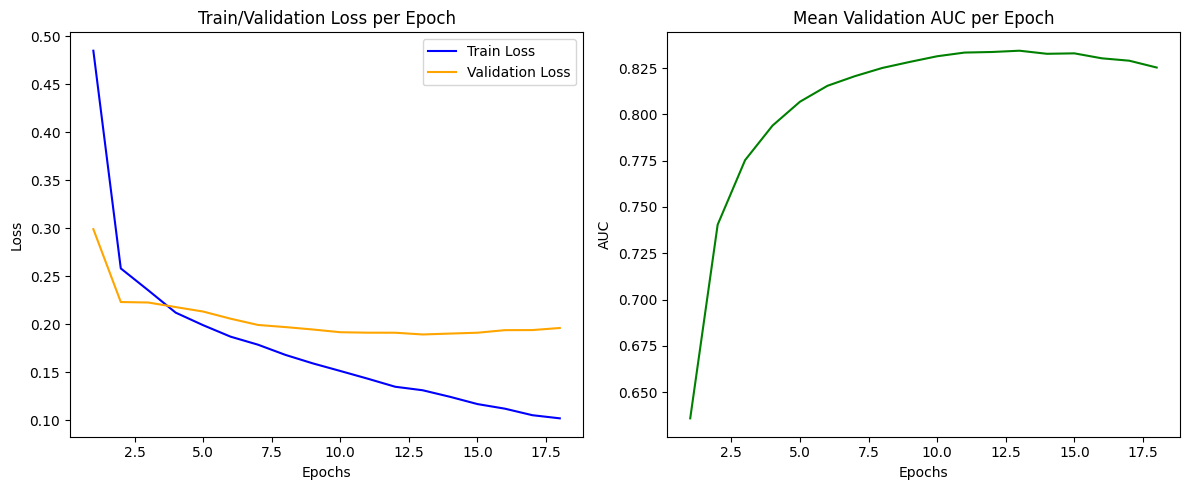

In [14]:
plot_losses(train_losses, val_losses, mean_auc_per_epoch, num_epochs_early_stopping)

**Test the model**

In [15]:
def test_model(model, test_loader, loss_func, device='cpu'):
    model.eval()
    total_test_loss = 0

    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            mask = (batch_y != -1.)
            loss = loss_func(outputs[mask], batch_y[mask])

            total_test_loss += loss.item() * batch_X.shape[0]

            test_outputs.append(outputs.cpu())
            test_labels.append(batch_y.cpu())

    test_loss = total_test_loss / len(test_loader.dataset)

    test_outputs = torch.cat(test_outputs)
    test_labels = torch.cat(test_labels)

    auc_scores = []

    for task in range(test_labels.shape[-1]):
        p = test_outputs[:, task]
        y = test_labels[:, task]

        mask = (y != -1)
        p = p[mask]
        y = y[mask]

        if 0 in y and 1 in y:
            auc = roc_auc_score(y, p)
        else:
            auc = np.nan

        auc_scores.append(auc)

    auc_scores_mean = np.nanmean(auc_scores)
    auc_scores_std = np.nanstd(auc_scores)
    return auc_scores_mean, auc_scores_std

In [16]:
auc_scores_mean, auc_scores_std = test_model(model, test_loader, loss_func)

In [17]:
print(f'Test AUC mean: {auc_scores_mean:.4f}, Test AUC std: {auc_scores_std:.4f}')

Test AUC mean: 0.8310, Test AUC std: 0.0469


**Save the model**

In [18]:
torch.save(model.state_dict(), ('dnn_best_model.pth'))